# ViT modelのrobust feature

## Robust feature 

### deit 定義

In [1]:
import argparse
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--model', type=str, default='vit_base_patch16_224')
    parser.add_argument('--method', type=str, default='pgd',
                        choices=['AT', 'TRADES', 'MART'])
    parser.add_argument('--dataset', type=str, default="cifar")
    parser.add_argument('--run-dummy', action='store_true')
    parser.add_argument('--accum-steps', type=int, default=1)
    parser.add_argument('--grad-clip', type=float, default=1.0)
    parser.add_argument('--test', action='store_true')
    parser.add_argument('--log-interval', type=int, default=10)
    parser.add_argument('--batch-size', default=64, type=int)
    parser.add_argument('--AA-batch', default=128, type=int,help="Batch size for AA.")5
    parser.add_argument('--crop', type=int, default=32)
    parser.add_argument('--resize', type=int, default=32)
    parser.add_argument('--load', action='store_true')
    parser.add_argument('--load_path', default='', type=str)
    parser.add_argument('--scratch', action='store_true')
    parser.add_argument('--n_w', type=int, default=10)
    parser.add_argument('--attack-iters', type=int, default=10, help='for pgd training')
    parser.add_argument('--patch', type=int, default=4)
    parser.add_argument('--ARD', action='store_true')
    parser.add_argument('--PRM', action='store_true')
    parser.add_argument('--drop-rate', default=1.0, type=float)
    parser.add_argument("--beta", type=float, default=6.0)
    parser.add_argument('--eval-restarts', type=int, default=1)
    parser.add_argument('--eval-iters', type=int, default=10)
    parser.add_argument('--data-dir', default='./data', type=str)
    parser.add_argument('--epochs', default=40, type=int)
    parser.add_argument('--lr-min', default=0., type=float)
    parser.add_argument('--lr-max', default=0.1, type=float)
    parser.add_argument('--weight-decay', default=1e-4, type=float)
    parser.add_argument('--momentum', default=0.9, type=float)
    parser.add_argument('--epsilon', default=8, type=int)
    parser.add_argument('--labelsmoothvalue', default=0, type=float)
    parser.add_argument('--alpha', default=2, type=float, help='Step size')
    parser.add_argument('--delta-init', default='random', choices=['zero', 'random', 'previous'],
                        help='Perturbation initialization method')
    parser.add_argument('--out-dir', '--dir', default='./log', type=str, help='Output directory')
    parser.add_argument('--seed', default=0, type=int, help='Random seed')
    parser.add_argument('--mixup', type=float, default=0.8,
                        help='mixup alpha, mixup enabled if > 0. (default: 0.8)')
    parser.add_argument('--cutmix', type=float, default=1.0,
                        help='cutmix alpha, cutmix enabled if > 0. (default: 1.0)')
    parser.add_argument('--cutmix-minmax', type=float, nargs='+', default=None,
                        help='cutmix min/max ratio, overrides alpha and enables cutmix if set (default: None)')
    parser.add_argument('--mixup-prob', type=float, default=0.3,
                        help='Probability of performing mixup or cutmix when either/both is enabled')
    parser.add_argument('--mixup-switch-prob', type=float, default=0.5,
                        help='Probability of switching to cutmix when both mixup and cutmix enabled')
    parser.add_argument('--mixup-mode', type=str, default='batch',
                        help='How to apply mixup/cutmix params. Per "batch", "pair", or "elem"')
    args = parser.parse_known_args()[0]
    assert args.batch_size % args.accum_steps == 0
    return args

In [2]:
""" Vision Transformer (ViT) in PyTorch

A PyTorch implement of Vision Transformers as described in:

'An Image Is Worth 16 x 16 Words: Transformers for Image Recognition at Scale'
    - https://arxiv.org/abs/2010.11929

`How to train your ViT? Data, Augmentation, and Regularization in Vision Transformers`
    - https://arxiv.org/abs/2106.10270

The official jax code is released and available at https://github.com/google-research/vision_transformer

DeiT model defs and weights from https://github.com/facebookresearch/deit,
paper `DeiT: Data-efficient Image Transformers` - https://arxiv.org/abs/2012.12877

Acknowledgments:
* The paper authors for releasing code and weights, thanks!
* I fixed my class token impl based on Phil Wang's https://github.com/lucidrains/vit-pytorch ... check it out
for some einops/einsum fun
* Simple transformer style inspired by Andrej Karpathy's https://github.com/karpathy/minGPT
* Bert reference code checks against Huggingface Transformers and Tensorflow Bert

Hacked together by / Copyright 2021 Ross Wightman
"""
import math
import logging
from functools import partial
from collections import OrderedDict
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from timm.models.helpers import build_model_with_cfg, named_apply, adapt_input_conv
from timm.models.layers import PatchEmbed, Mlp, DropPath, trunc_normal_, lecun_normal_


from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained

from timm.models.layers import  StdConv2dSame, DropPath, to_2tuple, trunc_normal_,lecun_normal_

_logger = logging.getLogger(__name__)


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic', 'fixed_input_size': True,
        'mean': IMAGENET_INCEPTION_MEAN, 'std': IMAGENET_INCEPTION_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }


default_cfgs = {
    # patch models (weights from official Google JAX impl)
    'vit_tiny_patch16_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz'),
    'vit_tiny_patch16_384': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384.npz',
        input_size=(3, 384, 384), crop_pct=1.0),
    'vit_small_patch32_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz'),
    'vit_small_patch32_384': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384.npz',
        input_size=(3, 384, 384), crop_pct=1.0),
    'vit_small_patch16_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz'),
    'vit_small_patch16_384': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384.npz',
        input_size=(3, 384, 384), crop_pct=1.0),
    'vit_base_patch32_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'B_32-i21k-300ep-lr_0.001-aug_medium1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz'),
    'vit_base_patch32_384': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'B_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384.npz',
        input_size=(3, 384, 384), crop_pct=1.0),
    'vit_base_patch16_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_224.npz'),
    'vit_base_patch16_384': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384.npz',
        input_size=(3, 384, 384), crop_pct=1.0),
    'vit_large_patch32_224': _cfg(
        url='',  # no official model weights for this combo, only for in21k
        ),
    'vit_large_patch32_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_p32_384-9b920ba8.pth',
        input_size=(3, 384, 384), crop_pct=1.0),
    'vit_large_patch16_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'L_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.1-sd_0.1--imagenet2012-steps_20k-lr_0.01-res_224.npz'),
    'vit_large_patch16_384': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'L_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.1-sd_0.1--imagenet2012-steps_20k-lr_0.01-res_384.npz',
        input_size=(3, 384, 384), crop_pct=1.0),

    # patch models, imagenet21k (weights from official Google JAX impl)
    'vit_tiny_patch16_224_in21k': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0.npz',
        num_classes=21843),
    'vit_small_patch32_224_in21k': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz',
        num_classes=21843),
    'vit_small_patch16_224_in21k': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz',
        num_classes=21843),
    'vit_base_patch32_224_in21k': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/B_32-i21k-300ep-lr_0.001-aug_medium1-wd_0.03-do_0.0-sd_0.0.npz',
        num_classes=21843),
    'vit_base_patch16_224_in21k': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0.npz',
        num_classes=21843),
    'vit_large_patch32_224_in21k': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_patch32_224_in21k-9046d2e7.pth',
        num_classes=21843),
    'vit_large_patch16_224_in21k': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/L_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.1-sd_0.1.npz',
        num_classes=21843),
    'vit_huge_patch14_224_in21k': _cfg(
        url='https://storage.googleapis.com/vit_models/imagenet21k/ViT-H_14.npz',
        hf_hub='timm/vit_huge_patch14_224_in21k',
        num_classes=21843),

    # deit models (FB weights)
    'deit_tiny_patch16_224': _cfg(
        url='https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth',
        mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    'deit_small_patch16_224': _cfg(
        url='https://dl.fbaipublicfiles.com/deit/deit_small_patch16_224-cd65a155.pth',
        mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    'deit_base_patch16_224': _cfg(
        url='https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth',
        mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    'deit_base_patch16_384': _cfg(
        url='https://dl.fbaipublicfiles.com/deit/deit_base_patch16_384-8de9b5d1.pth',
        mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD, input_size=(3, 384, 384), crop_pct=1.0),
    'deit_tiny_distilled_patch16_224': _cfg(
        url='https://dl.fbaipublicfiles.com/deit/deit_tiny_distilled_patch16_224-b40b3cf7.pth',
        mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD, classifier=('head', 'head_dist')),
    'deit_small_distilled_patch16_224': _cfg(
        url='https://dl.fbaipublicfiles.com/deit/deit_small_distilled_patch16_224-649709d9.pth',
        mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD, classifier=('head', 'head_dist')),
    'deit_base_distilled_patch16_224': _cfg(
        url='https://dl.fbaipublicfiles.com/deit/deit_base_distilled_patch16_224-df68dfff.pth',
        mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD, classifier=('head', 'head_dist')),
    'deit_base_distilled_patch16_384': _cfg(
        url='https://dl.fbaipublicfiles.com/deit/deit_base_distilled_patch16_384-d0272ac0.pth',
        mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD, input_size=(3, 384, 384), crop_pct=1.0,
        classifier=('head', 'head_dist')),

    # ViT ImageNet-21K-P pretraining by MILL
    'vit_base_patch16_224_miil_in21k': _cfg(
        url='https://miil-public-eu.oss-eu-central-1.aliyuncs.com/model-zoo/ImageNet_21K_P/models/timm/vit_base_patch16_224_in21k_miil.pth',
        mean=(0, 0, 0), std=(1, 1, 1), crop_pct=0.875, interpolation='bilinear', num_classes=11221,
    ),
    'vit_base_patch16_224_miil': _cfg(
        url='https://miil-public-eu.oss-eu-central-1.aliyuncs.com/model-zoo/ImageNet_21K_P/models/timm'
            '/vit_base_patch16_224_1k_miil_84_4.pth',
        mean=(0, 0, 0), std=(1, 1, 1), crop_pct=0.875, interpolation='bilinear',
    ),
}


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.v_mask = nn.Identity()

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        v = self.v_mask(v)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.mlp(self.norm2(x))
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer

    A PyTorch impl of : `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`
        - https://arxiv.org/abs/2010.11929

    Includes distillation token & head support for `DeiT: Data-efficient Image Transformers`
        - https://arxiv.org/abs/2012.12877
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None, weight_init=''):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
            weight_init: (str): weight init scheme
        """
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, drop=drop_rate,
                attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size and not distilled:
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ('fc', nn.Linear(embed_dim, representation_size)),
                ('act', nn.Tanh())
            ]))
        else:
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = None
        if distilled:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

        self.init_weights(weight_init)

    def init_weights(self, mode=''):
        assert mode in ('jax', 'jax_nlhb', 'nlhb', '')
        head_bias = -math.log(self.num_classes) if 'nlhb' in mode else 0.
        trunc_normal_(self.pos_embed, std=.02)
        if self.dist_token is not None:
            trunc_normal_(self.dist_token, std=.02)
        if mode.startswith('jax'):
            # leave cls token as zeros to match jax impl
            named_apply(partial(_init_vit_weights, head_bias=head_bias, jax_impl=True), self)
        else:
            trunc_normal_(self.cls_token, std=.02)
            self.apply(_init_vit_weights)

    def _init_weights(self, m):
        # this fn left here for compat with downstream users
        _init_vit_weights(m)

    @torch.jit.ignore()
    def load_pretrained(self, checkpoint_path, prefix=''):
        _load_weights(self, checkpoint_path, prefix)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token', 'dist_token'}

    def get_classifier(self):
        if self.dist_token is None:
            return self.head
        else:
            return self.head, self.head_dist

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        if self.num_tokens == 2:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])
        else:
            return x[:, 0], x[:, 1]

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])  # x must be a tuple
            if self.training and not torch.jit.is_scripting():
                # during inference, return the average of both classifier predictions
                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            x = self.head(x)
        return x


def _init_vit_weights(module: nn.Module, name: str = '', head_bias: float = 0., jax_impl: bool = False):
    """ ViT weight initialization
    * When called without n, head_bias, jax_impl args it will behave exactly the same
      as my original init for compatibility with prev hparam / downstream use cases (ie DeiT).
    * When called w/ valid n (module name) and jax_impl=True, will (hopefully) match JAX impl
    """
    if isinstance(module, nn.Linear):
        if name.startswith('head'):
            nn.init.zeros_(module.weight)
            nn.init.constant_(module.bias, head_bias)
        elif name.startswith('pre_logits'):
            lecun_normal_(module.weight)
            nn.init.zeros_(module.bias)
        else:
            if jax_impl:
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    if 'mlp' in name:
                        nn.init.normal_(module.bias, std=1e-6)
                    else:
                        nn.init.zeros_(module.bias)
            else:
                trunc_normal_(module.weight, std=.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    elif jax_impl and isinstance(module, nn.Conv2d):
        # NOTE conv was left to pytorch default in my original init
        lecun_normal_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, (nn.LayerNorm, nn.GroupNorm, nn.BatchNorm2d)):
        nn.init.zeros_(module.bias)
        nn.init.ones_(module.weight)


@torch.no_grad()
def _load_weights(model: VisionTransformer, checkpoint_path: str, prefix: str = ''):
    """ Load weights from .npz checkpoints for official Google Brain Flax implementation
    """
    import numpy as np

    def _n2p(w, t=True):
        if w.ndim == 4 and w.shape[0] == w.shape[1] == w.shape[2] == 1:
            w = w.flatten()
        if t:
            if w.ndim == 4:
                w = w.transpose([3, 2, 0, 1])
            elif w.ndim == 3:
                w = w.transpose([2, 0, 1])
            elif w.ndim == 2:
                w = w.transpose([1, 0])
        return torch.from_numpy(w)

    w = np.load(checkpoint_path)
    if not prefix and 'opt/target/embedding/kernel' in w:
        prefix = 'opt/target/'

    if hasattr(model.patch_embed, 'backbone'):
        # hybrid
        backbone = model.patch_embed.backbone
        stem_only = not hasattr(backbone, 'stem')
        stem = backbone if stem_only else backbone.stem
        stem.conv.weight.copy_(adapt_input_conv(stem.conv.weight.shape[1], _n2p(w[f'{prefix}conv_root/kernel'])))
        stem.norm.weight.copy_(_n2p(w[f'{prefix}gn_root/scale']))
        stem.norm.bias.copy_(_n2p(w[f'{prefix}gn_root/bias']))
        if not stem_only:
            for i, stage in enumerate(backbone.stages):
                for j, block in enumerate(stage.blocks):
                    bp = f'{prefix}block{i + 1}/unit{j + 1}/'
                    for r in range(3):
                        getattr(block, f'conv{r + 1}').weight.copy_(_n2p(w[f'{bp}conv{r + 1}/kernel']))
                        getattr(block, f'norm{r + 1}').weight.copy_(_n2p(w[f'{bp}gn{r + 1}/scale']))
                        getattr(block, f'norm{r + 1}').bias.copy_(_n2p(w[f'{bp}gn{r + 1}/bias']))
                    if block.downsample is not None:
                        block.downsample.conv.weight.copy_(_n2p(w[f'{bp}conv_proj/kernel']))
                        block.downsample.norm.weight.copy_(_n2p(w[f'{bp}gn_proj/scale']))
                        block.downsample.norm.bias.copy_(_n2p(w[f'{bp}gn_proj/bias']))
        embed_conv_w = _n2p(w[f'{prefix}embedding/kernel'])
    else:
        embed_conv_w = adapt_input_conv(
            model.patch_embed.proj.weight.shape[1], _n2p(w[f'{prefix}embedding/kernel']))
    model.patch_embed.proj.weight.copy_(embed_conv_w)
    model.patch_embed.proj.bias.copy_(_n2p(w[f'{prefix}embedding/bias']))
    model.cls_token.copy_(_n2p(w[f'{prefix}cls'], t=False))
    pos_embed_w = _n2p(w[f'{prefix}Transformer/posembed_input/pos_embedding'], t=False)
    if pos_embed_w.shape != model.pos_embed.shape:
        pos_embed_w = resize_pos_embed(  # resize pos embedding when different size from pretrained weights
            pos_embed_w, model.pos_embed, getattr(model, 'num_tokens', 1), model.patch_embed.grid_size)
    model.pos_embed.copy_(pos_embed_w)
    model.norm.weight.copy_(_n2p(w[f'{prefix}Transformer/encoder_norm/scale']))
    model.norm.bias.copy_(_n2p(w[f'{prefix}Transformer/encoder_norm/bias']))
    if isinstance(model.head, nn.Linear) and model.head.bias.shape[0] == w[f'{prefix}head/bias'].shape[-1]:
        model.head.weight.copy_(_n2p(w[f'{prefix}head/kernel']))
        model.head.bias.copy_(_n2p(w[f'{prefix}head/bias']))
    if isinstance(getattr(model.pre_logits, 'fc', None), nn.Linear) and f'{prefix}pre_logits/bias' in w:
        model.pre_logits.fc.weight.copy_(_n2p(w[f'{prefix}pre_logits/kernel']))
        model.pre_logits.fc.bias.copy_(_n2p(w[f'{prefix}pre_logits/bias']))
    for i, block in enumerate(model.blocks.children()):
        block_prefix = f'{prefix}Transformer/encoderblock_{i}/'
        mha_prefix = block_prefix + 'MultiHeadDotProductAttention_1/'
        block.norm1.weight.copy_(_n2p(w[f'{block_prefix}LayerNorm_0/scale']))
        block.norm1.bias.copy_(_n2p(w[f'{block_prefix}LayerNorm_0/bias']))
        block.attn.qkv.weight.copy_(torch.cat([
            _n2p(w[f'{mha_prefix}{n}/kernel'], t=False).flatten(1).T for n in ('query', 'key', 'value')]))
        block.attn.qkv.bias.copy_(torch.cat([
            _n2p(w[f'{mha_prefix}{n}/bias'], t=False).reshape(-1) for n in ('query', 'key', 'value')]))
        block.attn.proj.weight.copy_(_n2p(w[f'{mha_prefix}out/kernel']).flatten(1))
        block.attn.proj.bias.copy_(_n2p(w[f'{mha_prefix}out/bias']))
        for r in range(2):
            getattr(block.mlp, f'fc{r + 1}').weight.copy_(_n2p(w[f'{block_prefix}MlpBlock_3/Dense_{r}/kernel']))
            getattr(block.mlp, f'fc{r + 1}').bias.copy_(_n2p(w[f'{block_prefix}MlpBlock_3/Dense_{r}/bias']))
        block.norm2.weight.copy_(_n2p(w[f'{block_prefix}LayerNorm_2/scale']))
        block.norm2.bias.copy_(_n2p(w[f'{block_prefix}LayerNorm_2/bias']))


def resize_pos_embed(posemb, posemb_new, num_tokens=1, gs_new=()):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    _logger.info('Resized position embedding: %s to %s', posemb.shape, posemb_new.shape)
    ntok_new = posemb_new.shape[1]
    if num_tokens:
        posemb_tok, posemb_grid = posemb[:, :num_tokens], posemb[0, num_tokens:]
        ntok_new -= num_tokens
    else:
        posemb_tok, posemb_grid = posemb[:, :0], posemb[0]
    gs_old = int(math.sqrt(len(posemb_grid)))
    if not len(gs_new):  # backwards compatibility
        gs_new = [int(math.sqrt(ntok_new))] * 2
    assert len(gs_new) >= 2
    _logger.info('Position embedding grid-size from %s to %s', [gs_old, gs_old], gs_new)
    posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=gs_new, mode='bilinear')
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_new[0] * gs_new[1], -1)
    posemb = torch.cat([posemb_tok, posemb_grid], dim=1)
    return posemb


def checkpoint_filter_fn(state_dict, model,args):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    if 'model' in state_dict:
        # For deit models
        state_dict = state_dict['model']
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k and len(v.shape) < 4:
            # For old models that I trained prior to conv based patchification
            O, I, H, W = model.patch_embed.proj.weight.shape
            v = v.reshape(O, -1, H, W)
        elif k == 'pos_embed' and v.shape != model.pos_embed.shape:
            # To resize pos embedding when using model at different size from pretrained weights
            v = resize_pos_embed(
                v, model.pos_embed, getattr(model, 'num_tokens', 1), model.patch_embed.grid_size)
        elif k == 'patch_embed.proj.weight' and v.shape != model.patch_embed.proj.weight.shape:
            _logger.warning("Patch size doesn't match. ")
            if v.shape[2]%args.patch ==0:
                v = v.reshape(*v.shape[:2],
                    args.patch, v.shape[2]//args.patch,
                    args.patch, v.shape[3]//args.patch).sum(dim=[3,5])
            else:
                v = F.interpolate(v, model.patch_embed.proj.weight.shape[-1])
        out_dict[k] = v
    return out_dict


def _create_vision_transformer(variant, pretrained=False, default_cfg=None, **kwargs):
    default_cfg = default_cfg or default_cfgs[variant]
    if kwargs.get('features_only', None):
        raise RuntimeError('features_only not implemented for Vision Transformer models.')

    # NOTE this extra code to support handling of repr size for in21k pretrained models
    default_num_classes = default_cfg['num_classes']
    num_classes = kwargs.get('num_classes', default_num_classes)
    repr_size = kwargs.pop('representation_size', None)
    if repr_size is not None and num_classes != default_num_classes:
        # Remove representation layer if fine-tuning. This may not always be the desired action,
        # but I feel better than doing nothing by default for fine-tuning. Perhaps a better interface?
        _logger.warning("Removing representation layer for fine-tuning.")
        repr_size = None
    model = build_model_with_cfg(
        VisionTransformer, variant, pretrained,
        default_cfg=default_cfg,
        representation_size=repr_size,
        pretrained_filter_fn=partial(checkpoint_filter_fn , args=kwargs.pop('args')),
        pretrained_custom_load='npz' in default_cfg['url'],
        **kwargs)
    return model

def deit_tiny_patch16_224(pretrained=False, patch_size=16, args=None,**kwargs):
    """ DeiT-tiny model @ 224x224 from paper (https://arxiv.org/abs/2012.12877).
    ImageNet-1k weights from https://github.com/facebookresearch/deit.
    """
    model_kwargs = dict(patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, **kwargs)
    model = _create_vision_transformer('deit_tiny_patch16_224', pretrained=pretrained,args=args, **model_kwargs)
    return model



def deit_small_patch16_224(pretrained=False, patch_size=16, args=None, **kwargs):
    """ DeiT-small model @ 224x224 from paper (https://arxiv.org/abs/2012.12877).
    ImageNet-1k weights from https://github.com/facebookresearch/deit.
    """
    model_kwargs = dict(patch_size=patch_size, embed_dim=384, depth=12, num_heads=6, **kwargs)
    model = _create_vision_transformer('deit_small_patch16_224', pretrained=pretrained,args=args, **model_kwargs)
    return model

/home/y-sato/anaconda3/envs/vit-py3.8-conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### model load

In [3]:
# from .model_for_cifar.deit import deit_small_patch16_224
import torch
import torch.nn as nn


args = get_args()

crop_size = args.crop

model = deit_small_patch16_224(pretrained=True, img_size=crop_size, num_classes=10, patch_size=args.patch, args=args).cuda()
model = nn.DataParallel(model)
model.load_state_dict(torch.load('../results/trades_cifar_deit_small_p16_224/checkpoint_40')['state_dict'])
# torch.load('../results/nw_10.000000/checkpoint_40')['state_dict']

/home/y-sato/anaconda3/envs/vit-py3.8-conda/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
Patch size doesn't match. 


/home/y-sato/.cache/torch/hub/checkpoints/deit_small_patch16_224-cd65a155.pth


<All keys matched successfully>

In [47]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision

cifar10_mean = [0.4914, 0.4822, 0.4465]
cifar10_std = [0.2471, 0.2435, 0.2616]
transform_train = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(cifar10_mean, cifar10_std),
])
dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=False, transform=transform_train)
data_loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=4)

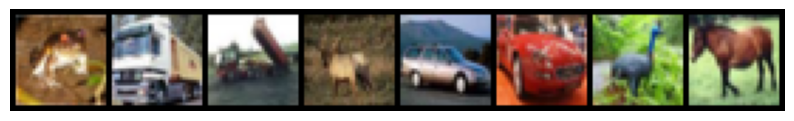

torch.Size([8, 3, 32, 32])

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# データローダーからバッチを取得
data_iter = iter(data_loader)
images, labels = data_iter.next()

# バッチから数枚の画像を表示する関数
def imshow(img):
    # img = img * cifar10_std + cifar10_mean
    npimg = img.numpy()
    # npimg = npimg * np.array(cifar10_std).reshape((3, 1, 1)) + np.array(cifar10_mean).reshape((3, 1, 1))
    # np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# 画像を表示
plt.figure(figsize=(10, 4))
imshow(torchvision.utils.make_grid(images[:8]))
plt.show()
images[:8].shape


In [6]:
x_natural = images[:8].cuda()
type(x_natural)
x_random = images[-8:].cuda()
# x_random.shape

print('target label:', labels[:24])
print('predict label:', model(x_natural).argmax(dim=1))

target label: tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6])
predict label: tensor([6, 9, 9, 4, 1, 1, 2, 7], device='cuda:0')


In [7]:
model.module.forward_features(x_natural).shape

torch.Size([8, 384])

In [8]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import torch.nn as nn

step_size = 0.1
perturb_steps = 1000
batch_size = len(x_natural)
# criterion_kl = torch.nn.KLDivLoss(size_average=False)
criterion_MSE = nn.MSELoss()
model = model.cuda()


# delta = torch.randn(x_natural.shape).cuda().detach()
delta = x_random.clone().detach().cuda()
delta = Variable(delta.data, requires_grad=True)
# Setup optimizers
optimizer_delta = optim.SGD([delta], lr=step_size)
mu = torch.tensor(cifar10_mean).view(3, 1, 1).cuda()
std = torch.tensor(cifar10_std).view(3, 1, 1).cuda()
upper_limit = ((1 - mu) / std)
lower_limit = ((0 - mu) / std)
for i in range(perturb_steps):
    # adv = x_natural + delta
    adv = delta
    # optimize
    optimizer_delta.zero_grad()
    with torch.enable_grad():
        # loss = (-1) * criterion_kl(F.log_softmax(model(adv), dim=1),
                                #    F.softmax(model(x_natural), dim=1))
        loss = criterion_MSE(model.module.forward_features(delta),
                            model.module.forward_features(x_natural))
    loss.backward()
    if i % 100 == 0:
        print(f'loss ({i}): {loss}')
    # renorming gradient
    grad_norms = delta.grad.view(batch_size, -1).norm(p=2, dim=1)
    delta.grad.div_(grad_norms.view(-1, 1, 1, 1))
    # avoid nan or inf if gradient is 0
    if (grad_norms == 0).any():
        delta.grad[grad_norms == 0] = torch.randn_like(delta.grad[grad_norms == 0])
    optimizer_delta.step()
    
    # これするとよくなる
    # delta.data.clamp_(lower_limit - x_natural, upper_limit - x_natural)
    delta.data.clamp_(lower_limit, upper_limit)
# x_adv = Variable(adv, requires_grad=False)
# x_adv = Variable(delta, requires_grad=False)

loss (0): 0.031880177557468414
loss (100): 0.015211428515613079
loss (200): 0.007185389753431082
loss (300): 0.003780866041779518
loss (400): 0.002109234221279621
loss (500): 0.0013614874333143234
loss (600): 0.0009459942812100053
loss (700): 0.0006811255589127541
loss (800): 0.0005051752086728811
loss (900): 0.00038479320937767625


In [9]:
x_adv = delta.clone().detach()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


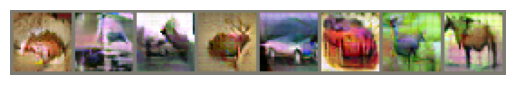

In [10]:
imshow(torchvision.utils.make_grid(x_adv.cpu().detach()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


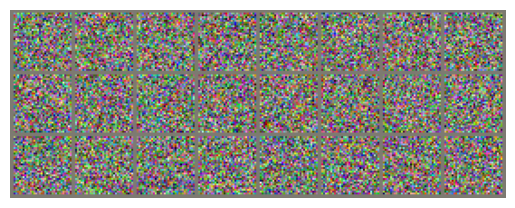

In [43]:
imshow(torchvision.utils.make_grid(torch.randn(x_natural.shape).cpu().detach()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


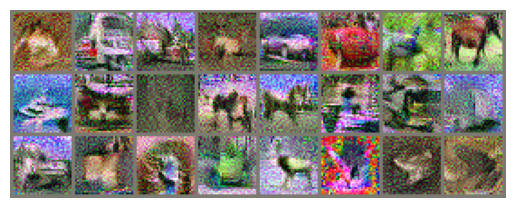

In [42]:
# imshow(torchvision.utils.make_grid(x_random.cpu().detach()))
imshow(torchvision.utils.make_grid(delta.cpu().detach()))

In [63]:
# standard training model
from models.resnet import ResNet50

model_s = deit_small_patch16_224(pretrained=True, img_size=crop_size, num_classes=10, patch_size=args.patch, args=args).cuda()
model_s = nn.DataParallel(model_s)
model_s.load_state_dict(torch.load('../results/vit-clean-standard/model-deit-epoch40.pt'))



/home/y-sato/anaconda3/envs/vit-py3.8-conda/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
Patch size doesn't match. 


/home/y-sato/.cache/torch/hub/checkpoints/deit_small_patch16_224-cd65a155.pth


<All keys matched successfully>

In [51]:
x_natural = images[:8].cuda()
y = labels[:8].cuda()
t = torch.randint(0, 10, y.shape).cuda()
t = labels[-8:].cuda()

In [52]:
print(y.shape == t.shape)
print(y)
print(t)

True
tensor([6, 9, 9, 4, 1, 1, 2, 7], device='cuda:0')
tensor([2, 2, 9, 2, 6, 6, 1, 9], device='cuda:0')


In [64]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import torch.nn as nn

# epsilon = 8 / 255
step_size = 0.1
epsilon = 5.0
perturb_steps = 100
batch_size = len(x_natural)
# cifar10_mean = (0.4914, 0.4822, 0.4465)
# cifar10_std = (0.2471, 0.2435, 0.2616)
# mu = torch.tensor(cifar10_mean).view(3, 1, 1).cuda()
# std = torch.tensor(cifar10_std).view(3, 1, 1).cuda()
# upper_limit = ((1 - mu) / std)
# lower_limit = ((0 - mu) / std)
# epsilon = (epsilon / 255.0) / std
# print(epsilon)
# print(type(epsilon))

criterion_CE = nn.CrossEntropyLoss()
model_s = model_s.cuda()

delta = 0.001 * torch.randn(x_natural.shape).cuda().detach()
delta = Variable(delta.data, requires_grad=True)

# Setup optimizers
optimizer_delta = optim.SGD([delta], lr=step_size)
# max_loss = torch.zeros(y.shape[0]).cuda()
# max_delta = torch.zeros_like(x_natural).cuda()

for _ in range(perturb_steps):
    adv = x_natural + delta
    # optimize
    optimizer_delta.zero_grad()
    with torch.enable_grad():
        loss = criterion_CE(model_s(adv), t)
    loss.backward()
    # renorming gradient
    grad_norms = delta.grad.view(batch_size, -1).norm(p=2, dim=1)
    delta.grad.div_(grad_norms.view(-1, 1, 1, 1))
    # avoid nan or inf if gradient is 0
    if (grad_norms == 0).any():
        delta.grad[grad_norms == 0] = torch.randn_like(delta.grad[grad_norms == 0])
    optimizer_delta.step()
    # projection
    delta.data.add_(x_natural.data)
    delta.data.clamp_(0, 1).sub_(x_natural.data)
    delta.data.renorm_(p=2, dim=0, maxnorm=epsilon)
x_adv = Variable(x_natural + delta, requires_grad=False)

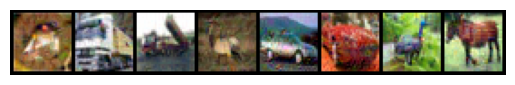

In [65]:
imshow(torchvision.utils.make_grid(x_adv.cpu().detach()))

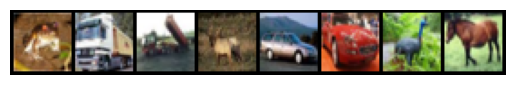

In [60]:
imshow(torchvision.utils.make_grid(x_natural.cpu().detach()))